In [2]:
pip install opencv-python opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


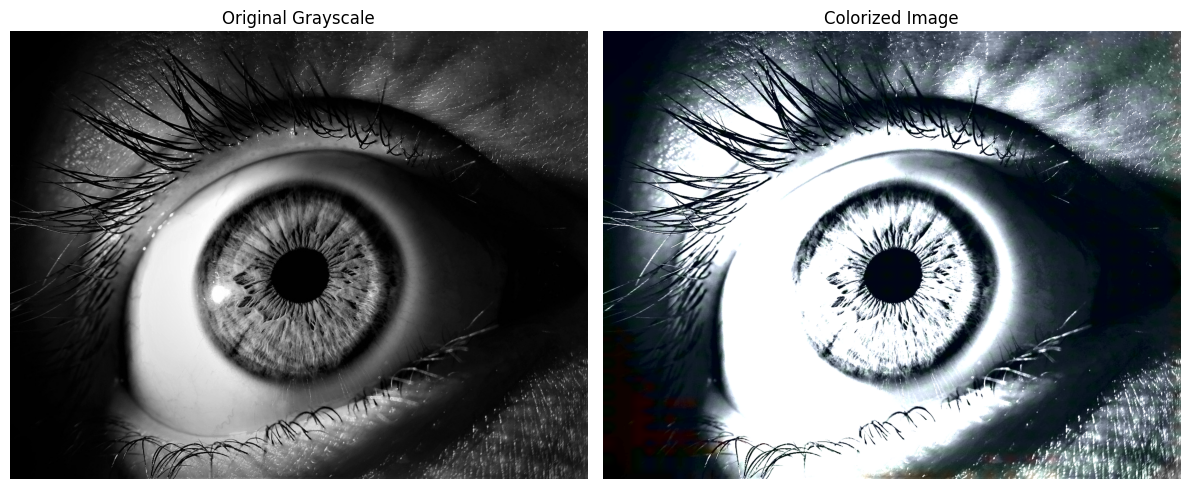

In [28]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Set paths to model and image ===
prototxt = '/kaggle/input/hj/other/default/1/colorization_deploy_v2.prototxt'
model = '/kaggle/input/hj/other/default/1/colorization_release_v2.caffemodel'
pts_in_hull ='/kaggle/input/hj/other/default/1/pts_in_hull.npy'
image_path = '/kaggle/input/eyes-o/eye.jpg'
  # Replace with your grayscale image

# === Step 2: Load the network and cluster centers ===
net = cv.dnn.readNetFromCaffe(prototxt, model)
pts = np.load(kernel_path)

# === Step 3: Add cluster centers to the model ===
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts.astype(np.float32)]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, dtype="float32")]

# === Step 4: Load the grayscale image ===
bgr = cv.imread(image_path)
if bgr is None:
    raise Exception("Image not found!")
h, w = bgr.shape[:2]
img_rgb = (bgr[:, :, [2, 1, 0]] / 255.0).astype(np.float32)

# Convert to Lab and extract L channel
lab = cv.cvtColor(bgr, cv.COLOR_BGR2Lab)
l_channel = lab[:, :, 0]

# Resize L channel to 224x224 as required by model
l_resized = cv.resize(l_channel, (224, 224))
l_resized -= 50  # Mean-centering
net.setInput(cv.dnn.blobFromImage(l_resized))

# === Step 5: Run forward pass to predict ab channels ===
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab = cv.resize(ab, (w, h))

# === Step 6: Combine with original L channel and convert back to BGR ===
lab_out = np.concatenate((l_channel[:, :, np.newaxis], ab), axis=2)
bgr_out = cv.cvtColor(lab_out.astype(np.float32), cv.COLOR_Lab2BGR)
bgr_out = np.clip(bgr_out, 0, 1)

# === Step 7: Display results ===
plt.figure(figsize=(12, 6))

# Grayscale
plt.subplot(1, 2, 1)
plt.title("Original Grayscale")
gray_img = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

# Colorized
plt.subplot(1, 2, 2)
plt.title("Colorized Image")
plt.imshow(bgr_out[:, :, ::-1])  # BGR to RGB
plt.axis('off')

plt.tight_layout()
plt.show()
